In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as sps

from utils_opt import *

%load_ext autoreload
%autoreload 2

# Test one shot sampling techniques

## Options
* Relaxed experiment design (lambda_i = m_i / m)
* Scalarization: 
    * D-optimal: (most widely used), minimize log-determinant (min volume)
    * E-optimal: minimize norm (min diameter) 
    * A-optimal: minimize the trace    

**Decision:** Going with D-optimal design, most common, easiest to write as DCP form

### Fake data

In [2]:
# make fake data
n, d = 100, 5
Sigma = np.random.normal(size=(d, d))
Sigma = Sigma.T @ Sigma
mu = np.random.normal(size=d)
# assume moving average system
X = np.random.multivariate_normal(mean=mu, cov=Sigma, size=n)

In [3]:
beta = np.random.normal(size=d)
f = X@beta + np.random.normal(size=n)

### Real data

In [4]:
D = 8
X = np.load('../data/pca_encoding.npy')[:,:D]
n, d = X.shape
# columns=['index', sample_num', 'operating_cost', 'market_rev', 'runtime'
f = pd.read_csv('../data/combined_hvdc.csv', header=None).to_numpy()[:,2]

In [5]:
fscale = StandardScaler().fit_transform(f.reshape(-1,1)).flatten()
Xscale = StandardScaler().fit_transform(X)

In [6]:
# scale and discretize
strategies = ['uniform', 'quantile', 'kmeans']
Xt, __, __ = scale_and_discretize(X, strategies[0], 10)

In [7]:
class dict_list(dict):
    def __init__(self):
        super(dict_list, self).__init__()
        self.__dict__ = self
        
    def add(self, k, v):
        if k in self:
            self[k].append(v)
        else:
            self[k] = [v]      

In [8]:
def get_stats(results, f, fpred):
    percentiles = [0, 10, 25, 50, 75, 90, 100]
    for p in percentiles:
        results.add(f'pctl_{p}', np.percentile(fpred, p))
    results.add('mean', np.mean(fpred))
    results.add('std', np.std(fpred))
    # comparison stats
    results.add('ttest', sps.ttest_ind(f, fpred).pvalue)
    results.add('komolgorov', sps.ks_2samp(f, fpred).pvalue)
    
    return results

# Pipeline

In [10]:
results = dict_list()

N = 25
for k in tqdm(range(10, N)):
    V, l, stats = doptimal(Xt, int(k*1.5))
    for i, v in stats.items():
        results.add(i,v)
    idxs = get_indices(Xt, V, l, k)
    results.add('n', len(idxs))
    
    Xk = Xscale[idxs]
    fk = fscale[idxs]
    fpred = sm.OLS(fk, sm.add_constant(Xk), hasconst=True).fit().predict(sm.add_constant(Xscale))
    results = get_stats(results, fscale, fpred)

100%|███████████████████████████████████████████| 15/15 [07:16<00:00, 29.13s/it]


## Visualize

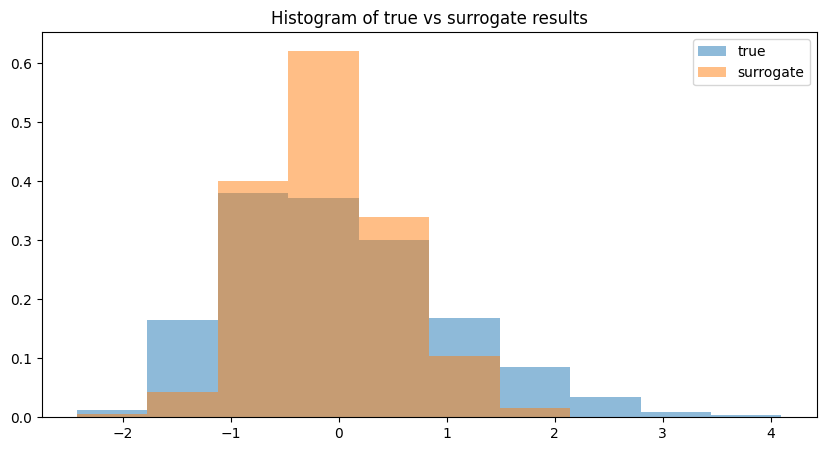

In [11]:
rlow, rhigh = np.minimum(np.min(fscale), np.min(fpred)), np.maximum(np.max(fscale), np.max(fpred))
plt.figure(figsize=(10,5))
plt.hist(fscale, alpha=0.5, label='true', range=(rlow, rhigh), density=True)
plt.hist(fpred, alpha=0.5, label='surrogate', range=(rlow, rhigh), density=True)
plt.title('Histogram of true vs surrogate results')
plt.legend()
plt.show()

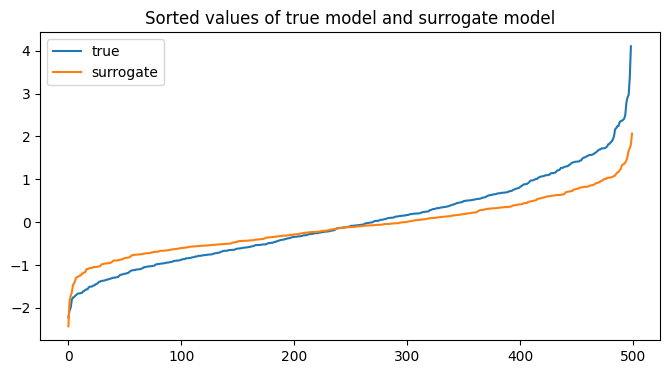

In [12]:
plt.figure(figsize=(8,4))
plt.plot(np.sort(fscale), label='true')
plt.plot(np.sort(fpred), label='surrogate')
plt.title('Sorted values of true model and surrogate model')
plt.legend()
plt.show()

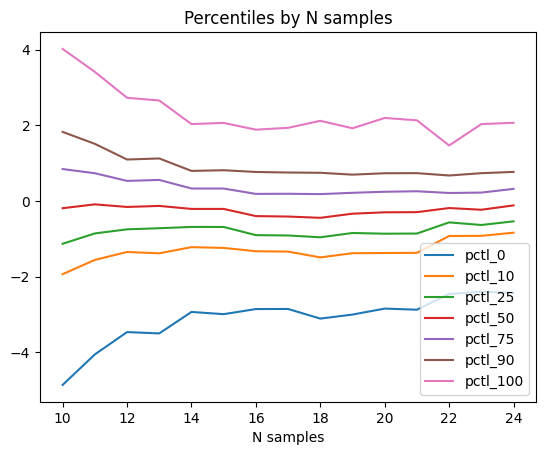

In [17]:
for k, v in results.items():
    if k.startswith('pctl'):
        plt.plot(results['n'], v, label=k)
plt.title('Percentiles by N samples')
plt.xlabel('N samples')
plt.legend()
plt.show()